In [1]:
import pandas as pd
import requests
import json
from base64 import b64encode, b64decode

In [28]:
s = 'eyJsYW5ndWFnZSI6InB0LWJyIiwicGFnZU51bWJlciI6MSwicGFnZVNpemUiOjIwLCJ0cmFkaW5nTmFtZSI6IkJSQVNJTCJ9'
url = 'https://sistemaswebb3-listados.b3.com.br/listedCompaniesProxy/CompanyCall/GetListedCashDividends/'
r=requests.get(url + s)
r.json()

{'page': {'pageNumber': 1,
  'pageSize': 20,
  'totalRecords': 264,
  'totalPages': 14},
 'results': [{'typeStock': 'ON',
   'dateApproval': '18/02/2025',
   'valueCash': '0,13600180735',
   'ratio': '1',
   'corporateAction': 'DIVIDENDO',
   'lastDatePriorEx': '11/03/2025',
   'dateClosingPricePriorExDate': '11/03/2025',
   'closingPricePriorExDate': '27,72',
   'quotedPerShares': '1',
   'corporateActionPrice': '0,490627',
   'lastDateTimePriorEx': '2025-03-11T00:00:00'},
  {'typeStock': 'ON',
   'dateApproval': '18/02/2025',
   'valueCash': '0,34259249436',
   'ratio': '1',
   'corporateAction': 'JRS CAP PROPRIO',
   'lastDatePriorEx': '11/03/2025',
   'dateClosingPricePriorExDate': '11/03/2025',
   'closingPricePriorExDate': '27,72',
   'quotedPerShares': '1',
   'corporateActionPrice': '1,235904',
   'lastDateTimePriorEx': '2025-03-11T00:00:00'},
  {'typeStock': 'ON',
   'dateApproval': '18/02/2025',
   'valueCash': '0,00354526413',
   'ratio': '1',
   'corporateAction': 'RENDIMEN

In [29]:
padrao = b64decode(s)
padrao

b'{"language":"pt-br","pageNumber":1,"pageSize":20,"tradingName":"BRASIL"}'

In [30]:
# max item/pagina = 120
s = b64encode(b'{"language":"pt-br","pageNumber":1,"pageSize":120,"tradingName":"BRASIL"}').decode()
s

'eyJsYW5ndWFnZSI6InB0LWJyIiwicGFnZU51bWJlciI6MSwicGFnZVNpemUiOjEyMCwidHJhZGluZ05hbWUiOiJCUkFTSUwifQ=='

In [31]:
r=requests.get(url + s)
print(r.json()['results'][-1])
r.json()

{'typeStock': 'ON', 'dateApproval': '12/05/2015', 'valueCash': '0,4511375655', 'ratio': '1', 'corporateAction': 'DIVIDENDO', 'lastDatePriorEx': '21/05/2015', 'dateClosingPricePriorExDate': '21/05/2015', 'closingPricePriorExDate': '24,63', 'quotedPerShares': '1', 'corporateActionPrice': '1,831659', 'lastDateTimePriorEx': '2015-05-21T00:00:00'}


{'page': {'pageNumber': 1,
  'pageSize': 120,
  'totalRecords': 264,
  'totalPages': 3},
 'results': [{'typeStock': 'ON',
   'dateApproval': '18/02/2025',
   'valueCash': '0,13600180735',
   'ratio': '1',
   'corporateAction': 'DIVIDENDO',
   'lastDatePriorEx': '11/03/2025',
   'dateClosingPricePriorExDate': '11/03/2025',
   'closingPricePriorExDate': '27,72',
   'quotedPerShares': '1',
   'corporateActionPrice': '0,490627',
   'lastDateTimePriorEx': '2025-03-11T00:00:00'},
  {'typeStock': 'ON',
   'dateApproval': '18/02/2025',
   'valueCash': '0,34259249436',
   'ratio': '1',
   'corporateAction': 'JRS CAP PROPRIO',
   'lastDatePriorEx': '11/03/2025',
   'dateClosingPricePriorExDate': '11/03/2025',
   'closingPricePriorExDate': '27,72',
   'quotedPerShares': '1',
   'corporateActionPrice': '1,235904',
   'lastDateTimePriorEx': '2025-03-11T00:00:00'},
  {'typeStock': 'ON',
   'dateApproval': '18/02/2025',
   'valueCash': '0,00354526413',
   'ratio': '1',
   'corporateAction': 'RENDIMEN

In [32]:
# Função para buscar o trading name
# https://www.b3.com.br/pt_br/produtos-e-servicos/negociacao/renda-variavel/empresas-listadas.htm
# a string é otida em <inspeçao> -> <rede>
def get_trading_name(ticker):

    params = {"language":"pt-br","pageNumber":1,"pageSize":20,"company":ticker}

   # Converte para JSON válido e depois para bytes
    encoded_params = json.dumps(params).encode('ascii')
    string = b64encode(encoded_params).decode()

    r = requests.get(r'https://sistemaswebb3-listados.b3.com.br/listedCompaniesProxy/CompanyCall/GetInitialCompanies/'+
                         string, verify = True)
    for i in r.json()['results']:
        if i['issuingCompany'].lower() == ticker.lower():
            return i['tradingName'].replace('/','').replace('.','')

    raise ValueError('Empresa não encontrada')


In [33]:
get_trading_name('embr')

'EMBRAER'

In [34]:
# Função para obter os proventos
def proventos(ticker):
    results = []
    n = 1
    tradingName = get_trading_name(ticker)
    while True:
        # cria os parâmetros com o trading name
        params = {"language":"pt-br","pageNumber":n,"pageSize":100,"tradingName":tradingName}

        # # codifica os parâmetros em base64
        # params = bytes(str(params), encoding="ascii")
        # string = b64encode(params)
        # string = string.decode()

         # codifica os parâmetros 
        encoded_params = json.dumps(params).encode("ascii")
        string = b64encode(encoded_params).decode()


        r = requests.get('https://sistemaswebb3-listados.b3.com.br/listedCompaniesProxy/CompanyCall/GetListedCashDividends/'+
                                 string, verify = True)

        if not r.json()['results']:
            break
        n += 1
            
        results += r.json()['results']
    return results

In [35]:
data = proventos("BBAS")
data

[{'typeStock': 'ON',
  'dateApproval': '18/02/2025',
  'valueCash': '0,13600180735',
  'ratio': '1',
  'corporateAction': 'DIVIDENDO',
  'lastDatePriorEx': '11/03/2025',
  'dateClosingPricePriorExDate': '11/03/2025',
  'closingPricePriorExDate': '27,72',
  'quotedPerShares': '1',
  'corporateActionPrice': '0,490627',
  'lastDateTimePriorEx': '2025-03-11T00:00:00'},
 {'typeStock': 'ON',
  'dateApproval': '18/02/2025',
  'valueCash': '0,34259249436',
  'ratio': '1',
  'corporateAction': 'JRS CAP PROPRIO',
  'lastDatePriorEx': '11/03/2025',
  'dateClosingPricePriorExDate': '11/03/2025',
  'closingPricePriorExDate': '27,72',
  'quotedPerShares': '1',
  'corporateActionPrice': '1,235904',
  'lastDateTimePriorEx': '2025-03-11T00:00:00'},
 {'typeStock': 'ON',
  'dateApproval': '18/02/2025',
  'valueCash': '0,00354526413',
  'ratio': '1',
  'corporateAction': 'RENDIMENTO',
  'lastDatePriorEx': '11/03/2025',
  'dateClosingPricePriorExDate': '11/03/2025',
  'closingPricePriorExDate': '27,72',
  

In [36]:
df = pd.DataFrame(data)
df.head(10)

,typeStock,dateApproval,valueCash,ratio,corporateAction,lastDatePriorEx,dateClosingPricePriorExDate,closingPricePriorExDate,quotedPerShares,corporateActionPrice,lastDateTimePriorEx
0,ON,18/02/2025,"0,13600180735",1,DIVIDENDO,11/03/2025,11/03/2025,"27,72",1,"0,490627",2025-03-11T00:00:00
1,ON,18/02/2025,"0,34259249436",1,JRS CAP PROPRIO,11/03/2025,11/03/2025,"27,72",1,"1,235904",2025-03-11T00:00:00
2,ON,18/02/2025,"0,00354526413",1,RENDIMENTO,11/03/2025,11/03/2025,"27,72",1,"0,012790",2025-03-11T00:00:00
3,ON,18/02/2025,"0,00893062309",1,RENDIMENTO,11/03/2025,11/03/2025,"27,72",1,"0,032217",2025-03-11T00:00:00
4,ON,19/02/2025,"0,14935148468",1,JRS CAP PROPRIO,11/03/2025,11/03/2025,"27,72",1,"0,538786",2025-03-11T00:00:00
5,ON,13/11/2024,"0,17649109403",1,JRS CAP PROPRIO,11/12/2024,11/12/2024,"25,36",1,"0,695943",2024-12-11T00:00:00
6,ON,11/11/2024,"0,48330421704",1,JRS CAP PROPRIO,25/11/2024,25/11/2024,"25,75",1,"1,876910",2024-11-25T00:00:00
7,ON,15/08/2024,"0,18660197784",1,JRS CAP PROPRIO,11/09/2024,11/09/2024,"28,71",1,"0,649955",2024-09-11T00:00:00
8,ON,05/08/2024,"0,15186078881",1,DIVIDENDO,21/08/2024,21/08/2024,"29,13",1,"0,521321",2024-08-21T00:00:00
9,ON,05/08/2024,"0,3144814886",1,JRS CAP PROPRIO,21/08/2024,21/08/2024,"29,13",1,"1,079579",2024-08-21T00:00:00


In [ ]:
# Converte 'valueCash' de string com vírgula para float
df["valueCash"] = df["valueCash"].str.replace(",", ".").astype(float)
# Extrai o ano da data de aprovação
df["year"] = pd.to_datetime(df["dateApproval"], dayfirst=True).dt.year
# Agrupa por ano e soma os proventos
proventos_anuais = df.groupby("year")["valueCash"].sum()


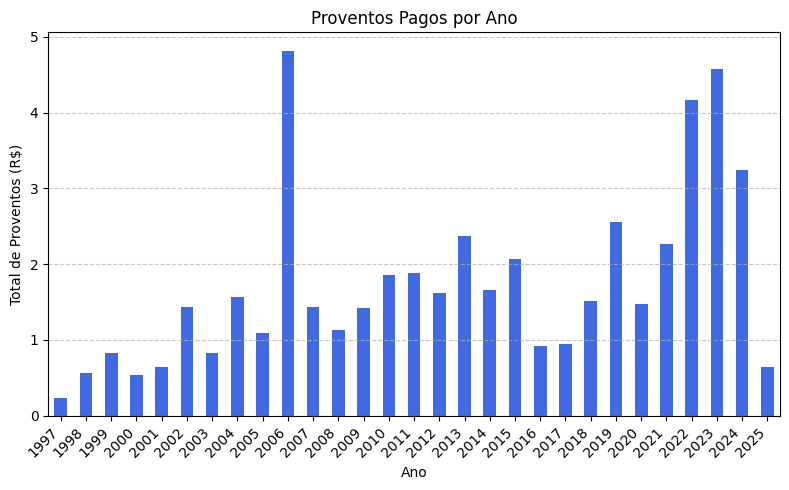

In [ ]:
import matplotlib.pyplot as plt


# Plota o gráfico
plt.figure(figsize=(8, 5))
proventos_anuais.plot(kind="bar", color="royalblue")
plt.title("Proventos Pagos por Ano")
plt.xlabel("Ano")
plt.ylabel("Total de Proventos (R$)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [38]:
df = pd.DataFrame(data)

In [ ]:
# Converte 'valueCash' de string com vírgula para float
df["valueCash"] = df["valueCash"].str.replace(",", ".").astype(float)
# Extrai o ano da data de aprovação
df["year"] = pd.to_datetime(df["dateApproval"], dayfirst=True).dt.year
# Agrupa por ano e soma os proventos
proventos_anuais = df.groupby("year")["valueCash"].sum().reset_index()


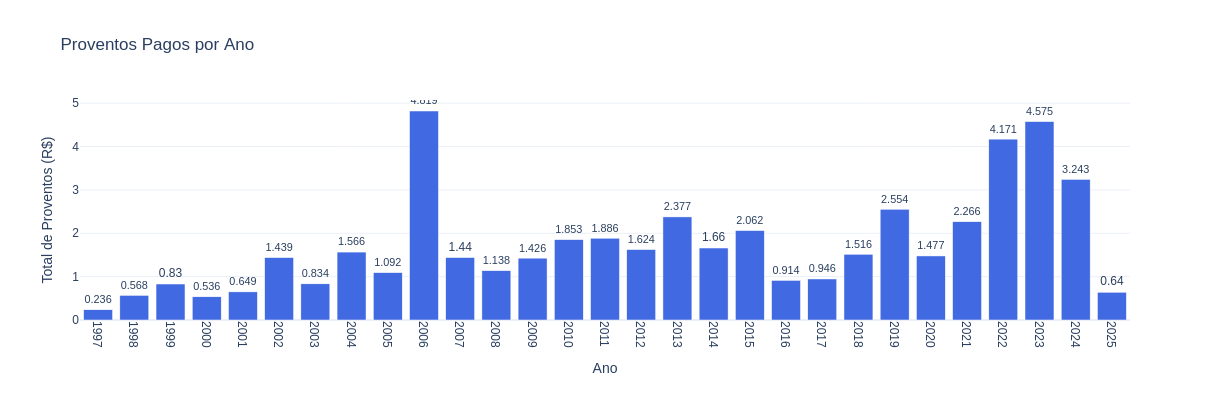

In [ ]:
import plotly.graph_objects as go

# Gráfico com Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=proventos_anuais["year_str"],
            y=proventos_anuais["valueCash"],
            marker_color="royalblue",
            text=proventos_anuais["valueCash"].round(3),
            textposition="outside"
        )
    ]
)

fig.update_layout(
    title="Proventos Pagos por Ano",
    xaxis_title="Ano",
    yaxis_title="Total de Proventos (R$)",
    xaxis_tickangle=90,
    template="plotly_white",
    height=400
)

fig.show()


In [15]:
# https://fabiomt.medium.com/como-obter-o-hist%C3%B3rico-de-dividendos-e-outros-proventos-com-python-direto-do-site-da-b3-90a507623418


In [20]:
codigo="BBAS3"#r.json()['results'][-1]['typeStock']

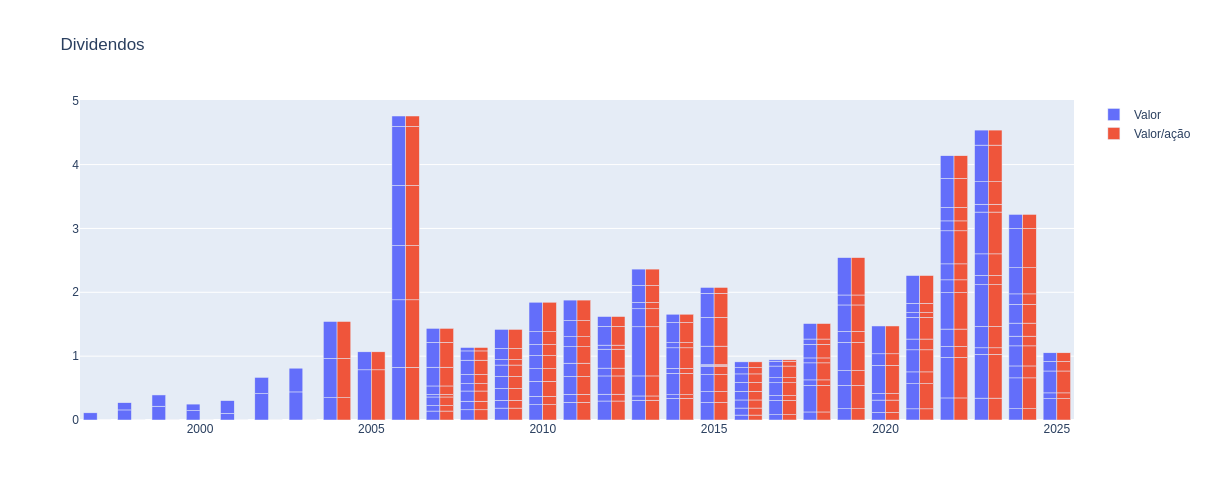

In [24]:
from io import StringIO

url1 = f'https://www.fundamentus.com.br/proventos.php?papel={codigo}&tipo=2'
header = { 
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36", "X-Requested-With": "XMLHttpRequest"
    }
r1 = requests.get(url1, headers=header)
dy = pd.read_html(StringIO(r1.text), decimal=',', thousands='.')[0]
dy['Data'] = pd.to_datetime(dy['Data'] , dayfirst=True)
dy.set_index('Data',inplace =True )
dy['Valor/acao'] = dy['Valor']/dy['Por quantas ações']

fig = go.Figure(
    [ go.Bar(x=dy.index.year , y = dy['Valor'],name='Valor'),
     go.Bar(x=dy.index.year , y = dy['Valor/acao'],name='Valor/ação')],
    layout=dict(title='Dividendos ',height=500, width=700 ))
fig.show()